# 准备工作

In [117]:
import pdb, os, shutil, datetime, math, sys, time, re

In [120]:
import zipfile

In [20]:
import scipy.stats as ss

In [21]:
import json

In [60]:
import lxml.etree as etree

In [22]:
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd

In [15]:
import tensorflow as tf

In [254]:
from sklearn import preprocessing

In [131]:
jobsdir = "../jobs_nobranch"
zipsdir = "../zips"

# 工具

## 获取路径

In [289]:
"""
返回：解调器文件路径、参数具有某一值的状态或控制文件的路径、返回某卫星得任务路径
"""
def getdirs(feature=None, value=None, jobdir=None, sat=None):
    # job下的所有解调器文件路径
    if jobdir:
        return [os.path.join(jobdir, demodname) for demodname in os.listdir(jobdir) if "Demod" in demodname]
    # 返回某卫星得任务路径
    elif sat:
        jobdirs = []
        for job in os.listdir(jobsdir):
            jobdir = os.path.join(jobsdir, job)
            tree = etree.parse(os.path.join(jobdir, "work_sch.xml"))
            if tree.find("./content/satelliteName").text == sat:
                jobdirs.append(jobdir)
        return jobdirs
    # feature参数具有value值得文件路径
    else:
        assert (feature and value)
        demodirs = []
        for job in os.listdir(jobsdir):
            for demodir in get_dirs(jobdir=os.path.join(jobsdir, job)):
                status = pd.read_csv(os.path.join(demodir, "valid/status.csv"), index_col="RECTIME")
                if value in list(status.loc[:, feature]):
                    demodirs.append(demodir)
        return demodirs

## 辅助观察数据的方法

### 查找控制或状态参数的全部值

In [441]:
def getvalue(feature, partfile):
    features_set = set()
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            file = os.path.join(demodir, partfile)
            try:
                status = pd.read_csv(file, index_col="RECTIME")
                for row in status.loc[:, feature]:
                    features_set.add(row)
            except:
                # 如果该文件里没有查询的参数名，输出文件名
                print(demodir)
    return features_set

# 预处理

## 读入任务配置文件

### 读入任务计划文件

首先清空jobs文件夹。\
WorkSch文件中存放了提前计算出的预计接收开始和结束时间。需利用这个接收开始和结束时间截取出有效时间段。\
可能有多个WorkSch文件，根据它的createdTime选择最新的WorkSch文件。

In [139]:
"""存储zip文件名的链表"""

#pattern = re.compile(r"Status_.*?Demod((QH)|(RW))[0-9]+?\.csv")
# 清华解调器的正则
pattern = re.compile(r"Status_.*?Demod(QH)[0-9]+?\.csv")

zips = [] # 将清华解调器的zip文件路劲存入这个链表中
for zipname in os.listdir(zipsdir):
    zipath = os.path.join(zipsdir, zipname)
    with zipfile.ZipFile(zipath) as zip_opened:
        for path in zip_opened.namelist():
            if pattern.search(path):
                # 如果是清华或者融为解调器的状态文件
                zips.append(zipname)
zips = list(set(zips))

In [146]:
if os.path.exists(jobsdir):
    shutil.rmtree(jobsdir)
os.mkdir(jobsdir)

for zipname in zips:
    newest = pd.Timestamp("1970-1-1")
    jobdir = os.path.join(jobsdir, os.path.splitext(os.path.split(zipname)[-1])[0])
    os.mkdir(jobdir)
    
    zipath = os.path.join(zipsdir, zipname)
    with zipfile.ZipFile(zipath) as zip_opened:
        for path in zip_opened.namelist():
            if "WorkSch_TASK" in path:
                workschfile = os.path.join(jobdir, "work_sch.xml")
                with zip_opened.open(path) as f:
                    tree = etree.parse(f)
                    # f 文件对象只能在parse中使用一次
                    # 找到文件创建时间
                    created = pd.Timestamp(
                            tree.find("./fileHeader/createdTime").text)
                    if created > newest:
                    # 提取最新的文件
                        newest = created
                        tree.write(workschfile)

### 读入设备列表文件
任务所用的所有设备都在列表文件里。要根据文件中对设备状态文件的属于的设备的描述提取出用于数据接收传输的设备状态文件

In [148]:
for zipname in zips:
    jobdir = os.path.join(jobsdir, os.path.splitext(os.path.split(zipname)[-1])[0])
    zipath = os.path.join(zipsdir, zipname)
    with zipfile.ZipFile(zipath) as zip_opened:
        for path in zip_opened.namelist():
            if "DeviceList" in path:
                file = os.path.join(jobdir, "device_list.xml")
                with zip_opened.open(path) as f:
                    with open(file, "wb") as f1:
                        f1.write(f.read())

## 解调器预处理描述

1. 根据任务的设备列表文件找到解调器的设备ID
2. 利用设备ID找到解调器的设备状态文件和控制文件，并保存
3. 从任务的任务计划文件中读出接收的开始和结束时间，利用接收时间段截取出有效时间段内的记录
4. 将解调器的状态参数按照信号处理流程划分为数个最小模块
5. 针对每个最小模块产生训练样本和测试样本

## 载入设备状态文件和控制文件

1. 清空原有的设备文件夹。
2. 在设备列表文件中找到解调器设备ID
3. 将相应设备状态文件载入设备文件夹

执行完成后，任务文件夹里多出如下文件：
* 任务名/
    * 解调器名/
        * raw/
            * status.csv
        * control.csv

In [149]:
# 从zip文件中解压缩具有设备的状态文件，存入raw
def extractfiles(jobdir, ID, zipath):
    statusfile = "Status_" + ID
    with zipfile.ZipFile(zipath) as zip_opened:
        for path in zip_opened.namelist():
            # 迭代找到zip文件里的解调器的状态文件和控制参数文件
            if "Status_" + ID in path:
                # 状态文件
                with zip_opened.open(path) as f:
                    with open(os.path.join(jobdir, ID + "/raw/status.csv"), "wb") as f1:
                        f1.write(f.read())
            elif "Control_" + ID in path:
                # 控制文件
                with zip_opened.open(path) as f:
                    with open(os.path.join(jobdir, ID + "/control.csv"), "wb") as f1:
                        f1.write(f.read())

for job in os.listdir(jobsdir):
    jobdir = os.path.join(jobsdir, job)
    # 删除原有的解调器文件夹
    for demodname in os.listdir(jobdir):
        if "Demod" in demodname:
            demodir = os.path.join(jobdir, demodname)
            shutil.rmtree(demodir)
    
    zipath = os.path.join(zipsdir, job + ".zip")
    devicelist = os.path.join(jobdir, "device_list.xml")
    tree = etree.parse(devicelist)
    devices = tree.findall("./content/deviceList/Device")
    for device in devices:
        ID = device.find("DevID").text
        if "Demod" in ID:
            # 新建解调器文件raw文件夹
            os.makedirs(os.path.join(jobdir, ID + "/raw"))
            extractfiles(jobdir, ID, zipath)

## 截取出有效接收时间范围内的记录

1. 首先清空每个解调器文件夹下的valid文件夹
2. 然后从work_sch.xml文件中读入数据接收的有效时间段
3. 根据有效时间段截取每个解调器的设备状态文件的有效记录，存入valid文件夹
执行完成后，任务文件里多出了如下文件：
* 任务名/
    * 解调器名/
        * valid/
            * status.csv

In [150]:
# 从任务文件夹中提取计划的接收任务开始时间和结束时间
def getvalidinterval(jobdir):
    workschfile = os.path.join(jobdir, "work_sch.xml")
    tree = etree.parse(workschfile)
    startime = "./content/equipmentInfo/receivingStartTime"
    endtime = "./content/equipmentInfo/receivingEndTime"
    startime = pd.Timestamp(tree.find(startime).text)
    endtime = pd.Timestamp(tree.find(endtime).text)
    return startime, endtime

# 利用任务的计划接收开始和结束时间截取解调器的有效状态
def extract_records(startime, endtime, statusdir):
    validir = os.path.join(statusdir, "valid")
    if os.path.exists(validir):
            shutil.rmtree(validir)
    os.mkdir(validir)

    raw = pd.read_csv(os.path.join(statusdir, "raw/status.csv"), index_col="RECTIME")
    index = pd.Series(data=raw.index).apply(lambda t: pd.Timestamp(t))
    # 在用值为bool的series作为索引之前，要把series转化为list
    index = (index >= startime) & (index <= endtime)
    valid = raw.loc[index.values, :]
    valid.to_csv(os.path.join(validir, "status.csv"), index_label="RECTIME")

# 截取
for job in os.listdir(jobsdir):
    jobdir = os.path.join(jobsdir, job)
    startime, endtime = getvalidinterval(jobdir)

    for demodir in getdirs(jobdir=jobdir):
        extract_records(startime,endtime, demodir)

## 工具

### 得到解调器的正常记录index
当一条记录的两个帧同步锁都锁上的时候说明该记录在帧同步锁之前的各个阶段均正常，即帧同步锁之前的各个部分用作正常训练样本。曾经考虑对于分路帧同步的情况，如果分路中某一个同步锁锁上了，则可以认为该记录在维特比译码之前各个阶段均正常，但是在分路的情况下，只有一个分路的帧同步锁上比方说I路，不能说明在分路之前的所有阶段均正确，所以舍弃这种做法。

In [153]:
"""正常样本和异常样本的索引。
清华解调器和融为解调器的帧同步合分的开关参数名称相同。
如果任务为分路帧同步，则需要I路和Q路的帧同步锁都锁上，才为正常样本；
如果任务为合路帧同步，则只需要I路的帧同步锁锁上，就为正常样本"""
def getnormalindex(demodir):
    # 都锁上
    def isalltrue(arr):
        for b in arr:
                if not b:
                    return False
        return True
    
    validstatus = pd.read_csv(os.path.join(demodir, "valid/status.csv"), index_col="RECTIME")
    control = pd.read_csv(os.path.join(demodir, "control.csv"), index_col="RECTIME")
    if control["DEMOD_FRAMESYNCINPUT"][0] == 1:
        # 合路，只需要I路的帧同步锁锁上即可
        normalindex = (validstatus["DPU_FRAMESYNCSTATUS1"] == 2).values
        return normalindex, ~normalindex
    elif control["DEMOD_FRAMESYNCINPUT"][0] == 2:
        # 分路，需要I、Q两路的帧同步锁都锁上
        normalindex = (validstatus.loc[:, ["DPU_FRAMESYNCSTATUS1", "DPU_FRAMESYNCSTATUS2"]] == 2).values
        normalindex = np.apply_along_axis(isalltrue, 1, normalindex)
        return normalindex, ~normalindex
    else:
        # 不做帧同步，直接返回空的numpy数组
        assert(control["DEMOD_FRAMESYNCINPUT"][0] == 0)
        return np.array([]), np.array([])   

### 按照 index拼接样本csv
为了解决前后两部分的“生成样本”时，相同的参数在两部分的处理工作重复的问题，设计该函数，把两个dataframe按照前一个打他frame的index进行拼接

In [161]:
"""第一个参数是基准样本文件的文件路径；第二个参数是拼接样本文件的文件路径"""
def concatbyindex(path1, path2):
    samples1 = pd.read_csv(path1, index_col="RECTIME")
    samples2 = pd.read_csv(path2, index_col="RECTIME")
    
    return pd.concat([samples1, samples2], axis=1, sort=False, join="inner")

### 提取属于某一阶段的参数

In [418]:
def extract_features():
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            sectiondir = os.path.join(demodir, partsectiondir)
            if os.path.exists(sectiondir):
                shutil.rmtree(sectiondir)
            os.mkdir(sectiondir)
    
            # 读入有效解调器设备状态参数
            validstatus = pd.read_csv(os.path.join(demodir, "valid/status.csv"), index_col="RECTIME")
            validstatus[features].to_csv(os.path.join(sectiondir, "status.csv"), index_label="RECTIME")

### 更改二元属性值
把各个二元属性的取值都改为0或1，存入regularized文件夹里

利用一个存放二元属性名和对应的应该为1的属性值的字典对原有数据进行更改， 形状如下：\
mappings = {"name1": 2, "name2": 2}

In [439]:
def regularize():
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            srcfile = os.path.join(demodir, partsrcfile)
            
            status = pd.read_csv(srcfile, index_col="RECTIME")
            for key, value in mappings.items():
                col = status.loc[:, key]
                result = np.zeros(col.size)
                result[col == value] = 1
                status.loc[:, key] = result
                
            regularizedir = os.path.join(os.path.join(demodir, partsectiondir), "regularized")
            if os.path.exists(regularizedir):
                shutil.rmtree(regularizedir)
            os.mkdir(regularizedir)
            status.to_csv(os.path.join(regularizedir, "status.csv"), index_label="RECTIME")

### 独热编码
用独热编码后的二元属性列代替原来的离散属性列

输入待独热编码的dataframe；编码规则——{keyname: [(name0, val0), (name1, val1), ..., (namek, valk)]}。

例如，如果keyname具有{0，1，2}三个取值，并且输入编码规则为：keyname: [(name0, 0), (name1, 1), (name2, 2)]那么输出的dataframe中不包含keyname列，取而代之的是name0、name1、name2三个列。当keyname取值为0时name0为1，其余两个属性为0；当keyname取值为1时name1为1、其余两个属性为0；当keyname取值为2时，其余两个属性为0

In [223]:
"""传入待独热编码的dataframe。
各个待编码的属性名和该属性名对应的取值{name: [(newname0, val0), (newname1, val1), ...]}"""
def onehot(status, **params):
    for keyname, rules in params.items():
        print(keyname, rules)
        for rule in rules:
            status[rule[0]] = (status[keyname].eq(rule[1])).astype("int32")
        status.drop(keyname, inplace=True, axis=1)
    return status

### 生成样本
通过帧同步锁产生正常和异常样本，或者根据前一部分的样本分别生成正常样本和异常样本

In [447]:
def generate_samples():
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            # 读入该阶段的数据
            sectiondir = os.path.join(demodir, partsectiondir)
            sectionstatus = pd.read_csv(os.path.join(sectiondir, "status.csv"), index_col="RECTIME")
            # 清空输入部分样本文件夹
            
            sampledir = os.path.join(demodir, partsampledir)
            if os.path.exists(sampledir):
                shutil.rmtree(sampledir)
            os.mkdir(sampledir)
            
            # 新建样本文件夹
            os.makedirs(os.path.join(sampledir, "normal/train"))
            os.mkdir(os.path.join(sampledir, "abnormal"))
            
            # 如果是第一阶段
            if not partlastsampledir:
                # 根据帧同步锁产生正常记录和异常记录的indexes
                normalindex, abnormalindex = getnormalindex(demodir)
                sectionstatus.loc[normalindex, :].to_csv(os.path.join(sampledir, "normal/train/samples.csv"), \
                    index_label="RECTIME")
                sectionstatus.loc[abnormalindex, :].to_csv(os.path.join(sampledir, "abnormal/samples.csv"), \
                    index_label="RECTIME")
            # 如果是下面的阶段
            else:
                lastsampledir = os.path.join(demodir, partlastsampledir)

                normalsamples = concatbyindex(os.path.join(lastsampledir, "normal/train/samples.csv"), \
                    os.path.join(sectiondir, "status.csv"))
                normalsamples.to_csv(os.path.join(sampledir, "normal/train/samples.csv"), index_label="RECTIME")
                abnormalsamples = concatbyindex(os.path.join(lastsampledir, "abnormal/samples.csv"), \
                    os.path.join(sectiondir, "status.csv"))
                abnormalsamples.to_csv(os.path.join(sampledir, "abnormal/samples.csv"), index_label="RECTIME")

### 正则化

In [454]:
"""输出拟合好的正则化器"""
def makescaler():
    trainsamples = []
    part_train_sample_file = os.path.join(partsectiondir, "samples/normal/train/samples.csv")
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            trainsample = pd.read_csv(os.path.join(demodir, part_train_sample_file), index_col="RECTIME")
            trainsamples.append(trainsample)
    trainsamples = pd.concat(trainsamples)
    # 拟合
    # 正则化器
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(trainsamples.loc[:, normfeatures])
    return scaler

"""用正则化器正则化训练样本和异常样本"""
def scalesamples():
    # 构造正则化器
    scaler = makescaler()
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            # 该部分的文件夹
            sectiondir = os.path.join(demodir, partsectiondir)
            
            # 正则化正常训练集
            prepdir = os.path.join(sectiondir, "samples/normal/train/preprocessed")
            if os.path.exists(prepdir):
                shutil.rmtree(prepdir)
            os.mkdir(prepdir)
            samples = pd.read_csv(os.path.join(sectiondir, "samples/normal/train/samples.csv"), index_col="RECTIME")
            
            if not samples.empty:
                samples.loc[:, normfeatures] = scaler.transform(samples.loc[:, normfeatures])
            """输出到磁盘的时候应该去除index，因为后面的tf在读取训练数据时不能识别字符串数据"""
            samples.to_csv(os.path.join(prepdir, "samples.csv"), index=False)
            
            
            # 正则化异常测试集
            prepdir = os.path.join(sectiondir, "samples/abnormal/preprocessed")
            if os.path.exists(prepdir):
                shutil.rmtree(prepdir)
            os.mkdir(prepdir)
            samples = pd.read_csv(os.path.join(sectiondir, "samples/abnormal/samples.csv"), index_col="RECTIME")
            
            if not samples.empty:
                samples.loc[:, normfeatures] = scaler.transform(samples.loc[:, normfeatures])
            samples.to_csv(os.path.join(prepdir, "samples.csv"), index_label="RECTIME")

## 划分描述
解调译码过程按照信号处理流程包含如下阶段：
* 中频输入
* 载波同步
* 比特同步
* 维特比译码（I/Q路）
* 帧同步（I/Q路）
* 译码和解扰（I/Q路）

新建parts文件夹，存放各部分的数据集

In [151]:
for job in os.listdir(jobsdir):
    for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
        partsdir = os.path.join(demodir, "parts")
        if os.path.exists(partsdir):
            shutil.rmtree(partsdir)
        os.mkdir(partsdir)

## 帧同步锁前
以帧同步锁为界限，把解调器的解调译码阶段分为两部分——帧同步锁前、帧同步锁后。

建立空的sync文件夹，存放帧同步锁前的数据集

执行后，文件结构如下：
* 任务名/
    * 解调器名/
        * parts/
            * sync/

In [152]:
for job in os.listdir(jobsdir):
    for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
        syncdir = os.path.join(demodir, "parts/sync")
        if os.path.exists(syncdir):
            shutil.rmtree(syncdir)
        os.mkdir(syncdir)

### 中频输入

#### 载入数据
建立空的input文件夹, 并将valid中的属于输入部分的状态参数存入status.csv

In [246]:
inputfeatures = ["DEMOD_IFLEVEL", "DEMOD_EBNOVALUE"]
features = inputfeatures.copy()
partsectiondir = "parts/sync/input"
extract_features()

#### 生成样本
利用帧同步锁生成正常训练样本和异常样本。该步进行完成后，文件夹具有如下结构：
* parts/
    * sync/
        * input/
            * status.csv
            * samples/
                * normal/
                    * train/
                        * samples.csv
                * abnormal/
                    * samples.csv

In [449]:
partsectiondir = "parts/sync/input"
partsampledir = "parts/sync/input/samples"
partlastsampledir = None
generate_samples()

#### 正则化
用正则化器适应训练集，再用正则化器去正则化训练集和测试集中的数值属性。将转化的结果存入preprocessed文件夹。该步执行完后，具有的文件夹结构如下：
* input/
    * samples/
        * normal/
            * train/
                * samples.csv
                * preprocessed/
                    * samples.csv
            * test/
                * samples.csv
                * preprocessed/
                    * samples.csv
        * abnormal/
            * samples.csv
            * preprocessed/
                * samples.csv

In [455]:
partsectiondir = "parts/sync/input"
normfeatures = inputfeatures
scalesamples()

### 载波同步

#### 载入数据

In [434]:
carrierfeatures = ["DEMOD_CARRIEROFFSET", "DEMOD_CARRIERLOCK"]
features = carrierfeatures.copy()
partsectiondir = "parts/sync/carrier"
extract_features()

#### 更改二元属性值

DEMOD_CARRIERLOCK属性为锁上时为2，没锁上为1，在此将锁上改为用1表示：
1. 将属性等于2的值改为1
2. 将属性等于其它值的域改为0

执行完成后文件结构如下：
* sync/
    * carrier/
        * status.csv
        * regularized/
            * status.csv

In [440]:
partsrcfile = "parts/sync/carrier/status.csv"
mappings = {"DEMOD_CARRIERLOCK": 2}
regularize()

#### 生成样本

In [462]:
partsectiondir = "parts/sync/carrier/regularized"
partsampledir = "parts/sync/carrier/samples"
partlastsampledir = "parts/sync/input/samples"
generate_samples()

#### 正则化

In [465]:
partsectiondir = "parts/sync/carrier"
normfeatures = inputfeatures + carrierfeatures
scalesamples()

# 构造、训练、测试模型

## 工具

### 算分

In [389]:
# 算分
def score_sample(sample):
    sample = tf.constant(sample[np.newaxis, :])
    encoded = encoder(sample)
    fake = decoder(encoded)
    # Apperant loss
    apperantloss = tf.reduce_mean(tf.losses.mean_absolute_error(sample, fake))

    # Latent loss
    encoded1 = encoder1(fake)
    latentloss = \
        tf.reduce_mean(tf.losses.mean_squared_error(encoded, encoded1))

    score = apperantloss + latentloss
    return score.numpy()

def score():
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            sampledir = os.path.join(demodir, partsampledir)
            
            # 如果计算训练数据的分数
            if "train" in sampledir:
                # 没有index
                prepsamples = pd.read_csv(os.path.join(sampledir, "preprocessed/samples.csv"))
                # 但要读入没有预处理的样本文件，以提供index
                samples = pd.read_csv(os.path.join(sampledir, "samples.csv"), index_col="RECTIME")
                # 训练数据为空，分数文件也为空
                if prepsamples.empty:
                    scores = pd.DataFrame(columns=["score"])
                else:
                    scores = pd.DataFrame(data=np.apply_along_axis(score_sample, 1, prepsamples.values), \
                          columns=["score"], index=samples.index)
            # 计算故障测试样本的分数
            else:
                prepsamples = pd.read_csv(os.path.join(sampledir, "preprocessed/samples.csv"), index_col="RECTIME")
                # 训练数据为空，分数文件也为空
                if prepsamples.empty:
                    scores = pd.DataFrame(columns=["score"])
                else:
                    scores = pd.DataFrame(data=np.apply_along_axis(score_sample, 1, prepsamples.values), \
                          columns=["score"], index=prepsamples.index)
                    
            # 存入磁盘        
            scores.to_csv(os.path.join(sampledir, "scores.csv"), index_label="RECTIME")

### 算异常样本的正确概率

In [644]:
def prob():
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            scores = pd.read_csv(os.path.join(demodir, partscorefile), index_col="RECTIME")
            probs = pd.DataFrame(\
                 data=scores["score"].apply(lambda s: 1 if s < gas_mean else ss.norm.sf(s, gas_mean, gas_sigma)), \
                 index=scores.index)
            probs.columns = ["prob"]
            probs.to_csv(os.path.join(demodir, partprobfile))

### 读入分数

In [417]:
def readscores():
    x = []
    y = []
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            #pdb.set_trace()
            scorefile = os.path.join(demodir, partscorefile)
            scores = pd.read_csv(scorefile, index_col="RECTIME")

            demod = os.path.split(demodir)[1]
            if not scores.empty:
                y.extend(scores["score"].values)
                x.extend([hash(demod + x1) for x1 in scores.index])
    return x, y

### 构造数据集

In [318]:
def makedataset():
    def split_line(line):
        record = tf.io.decode_csv(line, record_defaults=[0.] * featurenum)
        return tf.stack(record)
    
    dataset = tf.data.Dataset.list_files(jobsdir + trainfiles)
    dataset = dataset.interleave(lambda file: tf.data.TextLineDataset(file).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
    dataset = dataset.map(split_line, featurenum)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    return dataset

### 读入所有样本

In [313]:
def read_total_samples():
    samples_list = []
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            samples = pd.read_csv(os.path.join(demodir, partsamplefile))
            samples_list.append(samples)
    samples = pd.concat(samples_list)
    return tf.constant(samples.values, dtype=tf.float32)

### 构造优化器

In [314]:
def make_optimizer():
    steps = epochs * len(total_samples) // batch_size
    decay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, steps, 1e-1)
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=decay)
    discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=decay)
    return generator_optimizer, discriminator_optimizer

### 训练

In [525]:
# 训练函数
def train(): 
    def getloss(inputs):
        # Apperant loss
        encoded = gan.encoder(inputs)
        fakes = gan.decoder(encoded)
        apperantloss = tf.reduce_mean(tf.losses.mean_absolute_error(inputs, fakes))

        # Latent loss
        encoded1 = gan.encoder1(fakes)
        latentloss = \
        tf.reduce_mean(tf.losses.mean_squared_error(encoded, encoded1))

        # Feature matching loss
        preds = gan.feature_layer(fakes)
        reals = gan.feature_layer(inputs)
        featureloss = tf.reduce_mean(tf.losses.mean_squared_error(preds, reals))

        gloss = apperantloss + latentloss + featureloss
        return gloss
    
    # 在每个epoch后存储最小的ALoss和对应的， 每个epoch画一个点
    lastloss = np.inf

    for epoch in range(epochs):
        for batch in dataset:
            # Train discriminator
            # Generator fake samples
            encoded = gan.encoder(batch)
            fakes = gan.decoder(encoded)
            with tf.GradientTape() as discriminator_tape:
                # Train discriminator with real samples
                labels = tf.random.uniform(minval=0.7, maxval=1.2, seed=42, shape=(batch.shape[0], 1))
                preds = gan.discriminator(batch)
                loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels, preds))
            grads = discriminator_tape.gradient(loss, gan.discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(grads, gan.discriminator.trainable_variables))
            with tf.GradientTape() as discriminator_tape:
                # Train discriminator with fake samples
                labels = tf.random.uniform(minval=0., maxval=0.3, seed = 42, shape=(fakes.shape[0], 1))
                preds = gan.discriminator(fakes)
                loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels, preds))
            grads = discriminator_tape.gradient(loss, gan.discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(grads, gan.discriminator.trainable_variables))

            # Train genertor
            with tf.GradientTape() as generator_tape:
                loss = getloss(batch)
            # Insert all generator trainable variables into a list
            trainable_variables = []
            trainable_variables.extend(gan.encoder.trainable_variables)
            trainable_variables.extend(gan.decoder.trainable_variables)
            trainable_variables.extend(gan.encoder1.trainable_variables)

            grads = generator_tape.gradient(loss, trainable_variables)
            generator_optimizer.apply_gradients(zip(grads, trainable_variables))
            
            
        # 在整个训练集上计算generator的损失，并比较和上一次迭代的损失，如果小于上一次迭代，更新损失和最有模型；反之停止训练
        totaloss = getloss(total_samples)
        with summay_writer.as_default():
            tf.summary.scalar("A_loss", totaloss, epoch)
            
        if lastloss > totaloss.numpy():
            lastloss = totaloss.numpy()
            gan.encoder.save(encoderpath)
            gan.decoder.save(decoderpath)
            gan.encoder1.save(encoder1path)
        # 输出进度
        printbar(epoch)
        
def printbar(epoch):
    sys.stdout.write(f"\r{epoch:d}/{epochs}")
    sys.stdout.flush()

### 读出某个任务某个时刻的分数

In [602]:
def getscore():
    jobdir = os.path.join(jobsdir, job)
    demodir = os.path.join(jobdir, demod)
    scorefile = os.path.join(demodir, partscorefile)
    scores = pd.read_csv(scorefile, index_col="RECTIME")
    row = None
    for i in scores.index:
        if timestamp in i:
            row = i
            break
    return scores.loc[row, "score"]

### 输出符合某一规则的所有记录id

In [634]:
# 根据分数找到对应的任务名称
def findids():
    indexs = []
    for job in os.listdir(jobsdir):
        for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
            scores = pd.read_csv(os.path.join(demodir, partscorefile), \
                 index_col="RECTIME")
            if not scores.empty:
                indexs.extend([demodir + "---" + i for i in scores[tobool(scores)].index])
    return indexs

## 中频输入

### 构造建立模型

In [353]:
# 2
class GAN(object):
    def __init__(self):
        self.make_generator()
        self.make_discriminator()
        
    def make_generator(self):
        self.encoder = tf.keras.Sequential(name="Ge")
        self.encoder.add(tf.keras.Input(shape=(2,)))
        self.encoder.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.encoder.add(tf.keras.layers.LeakyReLU())

        self.decoder = tf.keras.Sequential(name="Gd")
        self.decoder.add(tf.keras.Input(shape=(1,)))
        self.decoder.add(tf.keras.layers.Dense(2, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.encoder1 = tf.keras.Sequential(name="Ge1")
        self.encoder1.add(tf.keras.Input(shape=(2,)))
        self.encoder1.add(tf.keras.layers.Dense(1, kernel_initializer="he_normal"))
        self.encoder1.add(tf.keras.layers.LeakyReLU())
        
    def make_discriminator(self):
        self.feature_layer = tf.keras.Sequential(name="DInner")
        self.feature_layer.add(tf.keras.Input(shape=(2,)))
        self.feature_layer.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.feature_layer.add(tf.keras.layers.LeakyReLU())
        self.feature_layer.add(tf.keras.layers.BatchNormalization())

        self.discriminator = tf.keras.Sequential([
            self.feature_layer,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [354]:
# 新建模型
gan = GAN()

### 构造数据集

In [355]:
# 构造dataset
trainfiles = "/*/*/parts/sync/input/samples/normal/train/preprocessed/samples.csv"
featurenum = 2
batch_size = 256
epochs = 10000
dataset = makedataset()

In [399]:
# 读入所有训练样本
partsamplefile = "parts/sync/input/samples/normal/train/preprocessed/samples.csv"
total_samples = read_total_samples()

### 训练

In [358]:
# 清空并新建log
logdir = "logs/ad/sync/input/(2,1)_(2,2)"
if os.path.exists(logdir):
        shutil.rmtree(logdir)
    os.makedirs(logdir)

In [359]:
summay_writer = tf.summary.create_file_writer(logdir)

In [360]:
# 优化器
generator_optimizer, discriminator_optimizer = make_optimizer()

In [373]:
# 保存模型
encoderfile = "encoder.h5"
decoderfile = "decoder.h5"
encoder1file = "encoder1.h5"
modeldir = "models/ad/sync/input/(2,1)_(2,2)"
encoderpath = os.path.join(modeldir, encoderfile)
decoderpath = os.path.join(modeldir, decoderfile)
encoder1path = os.path.join(modeldir, encoder1file)

In [ ]:
# 清空模型文件夹
if os.path.exists(modeldir):
    shutil.rmtree(modeldir)
os.makedirs(modeldir)

In [511]:
# 开始训练
train()

41/10000

KeyboardInterrupt: 

### 评估
然后利用训练好的模型算出测试集样本的分数，存档。

从文件夹中载入训练好的模型。

遍历每个解调器的测试集，将相应的分数存入preprocessed/scores.csv中

In [374]:
encoder = tf.keras.models.load_model(encoderpath)
decoder = tf.keras.models.load_model(decoderpath)
encoder1 = tf.keras.models.load_model(encoder1path)

计算测试样本分数并存档
执行后：
* samples/
    * normal/
        * test/
            * preprocessed/
                * samples.csv
                * scores.csv
    * abnormal/
        * preprocessed/
            * samples.csv
            * scores.csv

In [456]:
# 算出正常训练集和异常测试集的分数
# train samples
partsampledir = "parts/sync/input/samples/normal/train"
score()

# abnormal
partsampledir = "parts/sync/input/samples/abnormal"
score()

In [646]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
partscorefile = "parts/sync/input/samples/normal/train/scores.csv"
normal_x, normal_y = readscores()
partscorefile = "parts/sync/input/samples/abnormal/scores.csv"
abnormal_x, abnormal_y = readscores()

"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
inputmean = np.mean(normal_y)
inputsigma = np.var(normal_y)
gas_mean = inputmean
gas_sigma = inputsigma
partprobfile = "parts/sync/input/samples/abnormal/probs.csv"
prob()

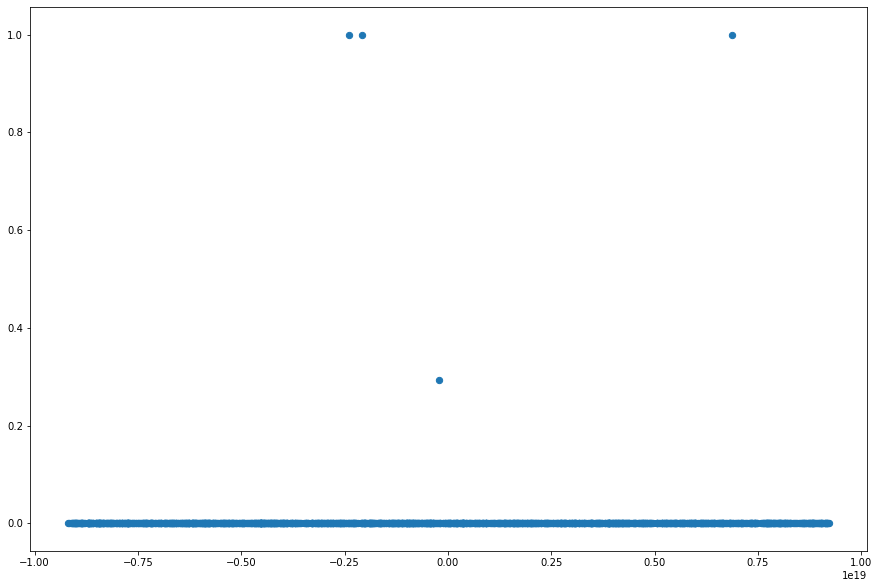

In [647]:
plt.figure(figsize=(15, 10))
plt.scatter(abnormal_x, abnormalprobs, s=40)
plt.show()

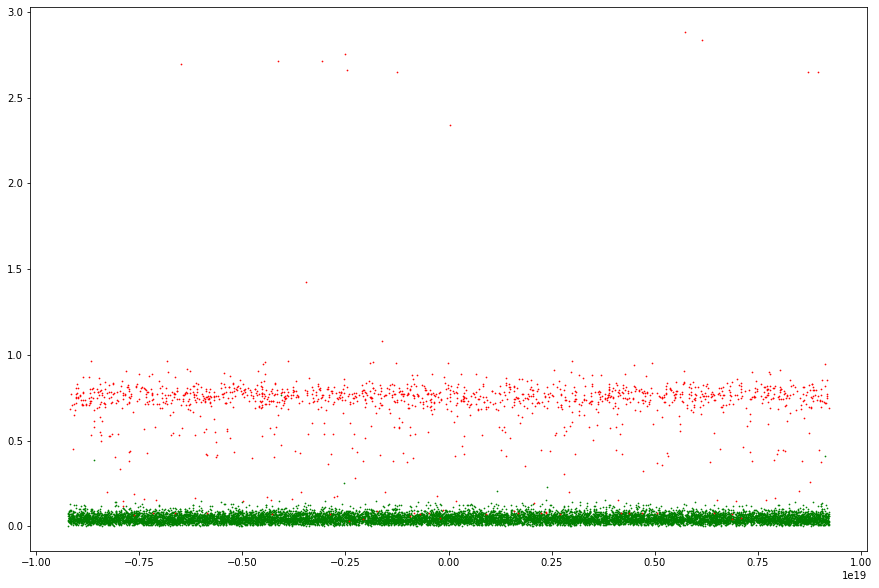

In [648]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.scatter(normal_x, normal_y, c="green", s=0.5)
plt.scatter(abnormal_x, abnormal_y, c="red", s=0.5)
plt.show()

In [636]:
def tobool(scores):
    return scores["score"].lt(0.25)

partscorefile = "parts/sync/input/samples/abnormal/scores.csv"
ids = findids()

In [604]:
job = "JOB201912276594418"
demod = "KJ_HDemodQH1"
partscorefile = "parts/sync/input/samples/abnormal/scores.csv"
timestamp = "8:05:57"
getscore()

0.42049790000000004

In [664]:
probdir = "../probs"
if os.path.exists(probdir):
    shutil.rmtree(probdir)
os.mkdir(probdir)

partsampledir = "parts/sync/input/samples/abnormal"
for job in os.listdir(jobsdir):
    for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
        demod = os.path.split(demodir)[1]
        
        probs = pd.read_csv(os.path.join(demodir, os.path.join(partsampledir, "probs.csv")), index_col="RECTIME")
        samples = pd.read_csv(os.path.join(demodir, os.path.join(partsampledir, "samples.csv")), index_col="RECTIME")
        
        for i in samples.index:
            info = {}
            for col in samples.columns:
                info[col] = samples.loc[i, col]
            info["正确率"] = probs.loc[i, "prob"]
            info = json.dumps(info, ensure_ascii=False)
            with open(os.path.join(probdir, job + "&" + demod + "&" + i[-8:].replace(":", "_") + ".json"), "wb") as fb:
                fb.write(str.encode(info))

## 载波同步

### 构造建立模型

In [515]:
# 4
class GAN(object):
    def __init__(self):
        self.make_generator()
        self.make_discriminator()
        
    def make_generator(self):
        self.encoder = tf.keras.Sequential(name="Ge")
        self.encoder.add(tf.keras.Input(shape=(4,)))
        self.encoder.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.encoder.add(tf.keras.layers.LeakyReLU())
        self.encoder.add(tf.keras.layers.BatchNormalization())
        self.encoder.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.encoder.add(tf.keras.layers.LeakyReLU())

        self.decoder = tf.keras.Sequential(name="Gd")
        self.decoder.add(tf.keras.Input(shape=(2,)))
        self.decoder.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.decoder.add(tf.keras.layers.LeakyReLU())
        self.decoder.add(tf.keras.layers.BatchNormalization())
        self.decoder.add(tf.keras.layers.Dense(4, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.encoder1 = tf.keras.Sequential(name="Ge1")
        self.encoder1.add(tf.keras.Input(shape=(4,)))
        self.encoder1.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.encoder1.add(tf.keras.layers.LeakyReLU())
        self.encoder1.add(tf.keras.layers.BatchNormalization())
        self.encoder1.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.encoder1.add(tf.keras.layers.LeakyReLU())
        
    def make_discriminator(self):
        self.feature_layer = tf.keras.Sequential(name="DInner")
        self.feature_layer.add(tf.keras.Input(shape=(4,)))
        self.feature_layer.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.feature_layer.add(tf.keras.layers.LeakyReLU())
        self.feature_layer.add(tf.keras.layers.BatchNormalization())
        self.feature_layer.add(tf.keras.layers.Dense(2, kernel_initializer="he_normal"))
        self.feature_layer.add(tf.keras.layers.LeakyReLU())
        self.feature_layer.add(tf.keras.layers.BatchNormalization())

        self.discriminator = tf.keras.Sequential([
            self.feature_layer,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [526]:
# 新建模型
tf.keras.backend.clear_session()
gan = GAN()

### 构造数据集

In [527]:
# 构造dataset
trainfiles = "/*/*/parts/sync/carrier/samples/normal/train/preprocessed/samples.csv"
featurenum = 4
batch_size = 256
epochs = 10000
dataset = makedataset()

In [528]:
# 读入所有训练样本
partsamplefile = "parts/sync/carrier/samples/normal/train/preprocessed/samples.csv"
total_samples = read_total_samples()

### 训练

In [529]:
# 清空并新建log
logdir = "logs/ad/sync/carrier/(4,2)_(4,2)"
if os.path.exists(logdir):
    shutil.rmtree(logdir)

In [530]:
os.makedirs(logdir)
summay_writer = tf.summary.create_file_writer(logdir)

In [531]:
# 优化器
generator_optimizer, discriminator_optimizer = make_optimizer()

In [652]:
# 保存模型
encoderfile = "encoder.h5"
decoderfile = "decoder.h5"
encoder1file = "encoder1.h5"

modeldir = "models/ad/sync/carrier/(4,2)_(4,2)"

encoderpath = os.path.join(modeldir, encoderfile)
decoderpath = os.path.join(modeldir, decoderfile)
encoder1path = os.path.join(modeldir, encoder1file)

In [ ]:
# 清空模型文件夹
if os.path.exists(modeldir):
    shutil.rmtree(modeldir)
os.makedirs(modeldir)

In [533]:
# 开始训练
train()

497/10000

KeyboardInterrupt: 

### 评估

In [653]:
encoder = tf.keras.models.load_model(encoderpath)
decoder = tf.keras.models.load_model(decoderpath)
encoder1 = tf.keras.models.load_model(encoder1path)

In [535]:
# 算出正常训练集和异常测试集的分数
# train samples
partsampledir = "parts/sync/carrier/samples/normal/train"
score()

# abnormal
partsampledir = "parts/sync/carrier/samples/abnormal"
score()

In [655]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
partscorefile = "parts/sync/carrier/samples/normal/train/scores.csv"
normal_x, normal_y = readscores()
partscorefile = "parts/sync/carrier/samples/abnormal/scores.csv"
abnormal_x, abnormal_y = readscores()

"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
inputmean = np.mean(normal_y)
inputsigma = np.var(normal_y)
gas_mean = inputmean
gas_sigma = inputsigma
partprobfile = "parts/sync/carrier/samples/abnormal/probs.csv"
prob()

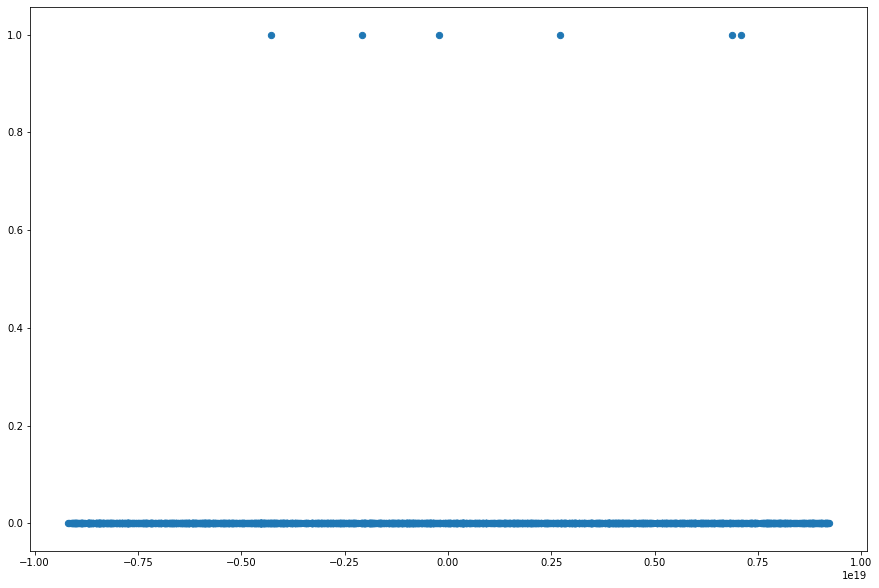

In [656]:
plt.figure(figsize=(15, 10))
plt.scatter(abnormal_x, abnormalprobs, s=40)
plt.show()

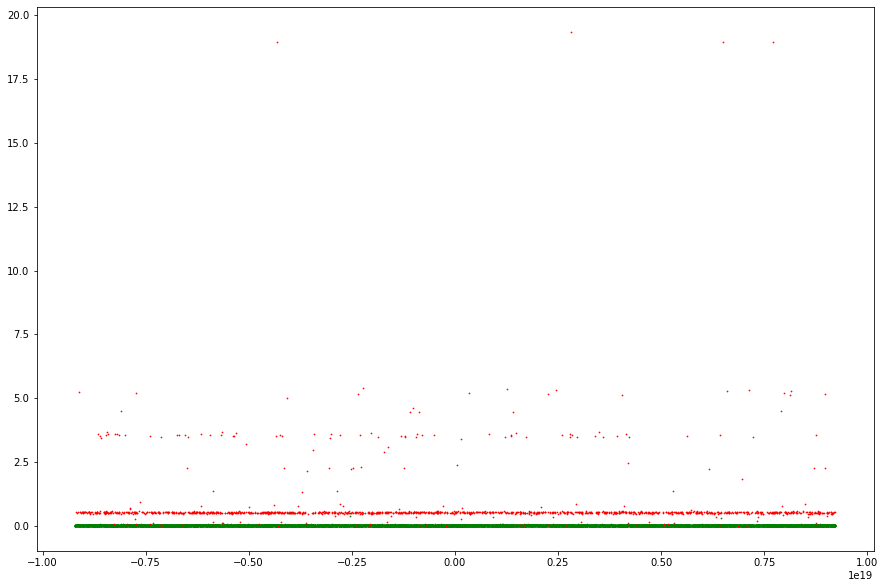

In [657]:
# 做出散点图。其中，虚线表示阈值。
plt.figure(figsize=(15, 10))
plt.scatter(normal_x, normal_y, c="green", s=0.5)
plt.scatter(abnormal_x, abnormal_y, c="red", s=0.5)
plt.show()

## 比特同步

### 构造建立模型

In [129]:
# 10参数
class GANbit(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(10,)))
        self.oSeqGe.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(5,)))
        self.oSeqGd.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(10, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(10,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(10,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(5, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [130]:
# 新建模型
oGANbit = GANbit()

### 构造数据集

In [131]:
g_nFeatures = 10
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [132]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/bit/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [133]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [134]:
strD = "(10,5)_D"
strA = "(10,5)_A"
strRootDir = "logs/nobranch/sync/bit"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [136]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [137]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANbit)

397/10000

KeyboardInterrupt: 

In [105]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/bit"
strModelsDir = os.path.join(strRootDir, "(10,5)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [139]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [140]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [106]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [142]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/bit/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [21]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [22]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/bit/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [23]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanbit = np.mean(npNormalScores)
fSigmabit = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanbit else ss.norm.sf(x, fMeanbit, fSigmabit), 1, \
     npAbnormalScores[:, np.newaxis])

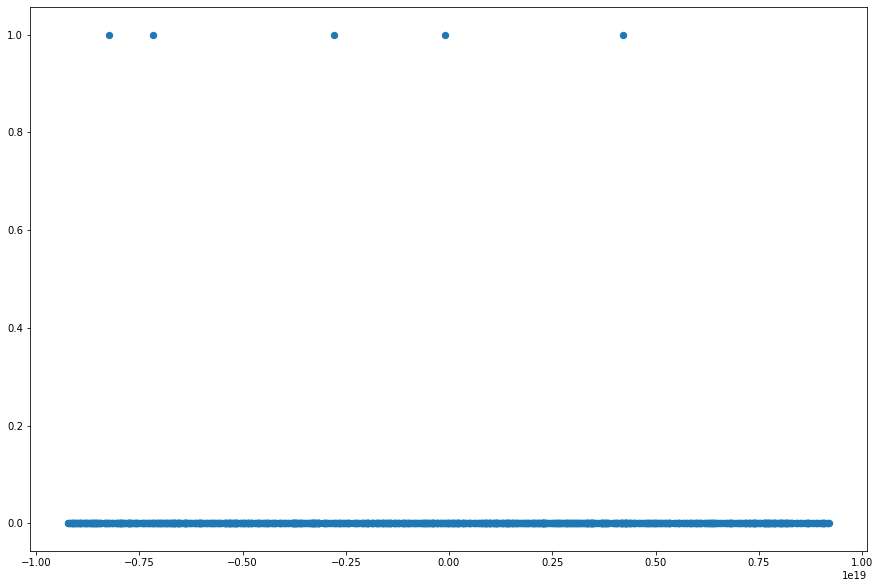

In [24]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 维特比译码

### 构造建立模型

In [175]:
# 17参数
class GANvi(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(17,)))
        self.oSeqGe.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(8,)))
        self.oSeqGd.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(17, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(17,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(17,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(8, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [176]:
# 新建模型
tf.keras.backend.clear_session()
oGANvi = GANvi()

### 构造数据集

In [177]:
g_nFeatures = 17
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/vi/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [160]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/vi/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [178]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [179]:
strD = "(17,8)_D"
strA = "(17,8)_A"
strRootDir = "logs/nobranch/sync/vi"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [180]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [181]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANvi)

1591/10000

KeyboardInterrupt: 

In [112]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/vi"
strModelsDir = os.path.join(strRootDir, "(17,8)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [182]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [183]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [113]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [114]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/vi/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [25]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/vi/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [26]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/vi/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [27]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanvi = np.mean(npNormalScores)
fSigmavi = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanvi else ss.norm.sf(x, fMeanvi, fSigmavi), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

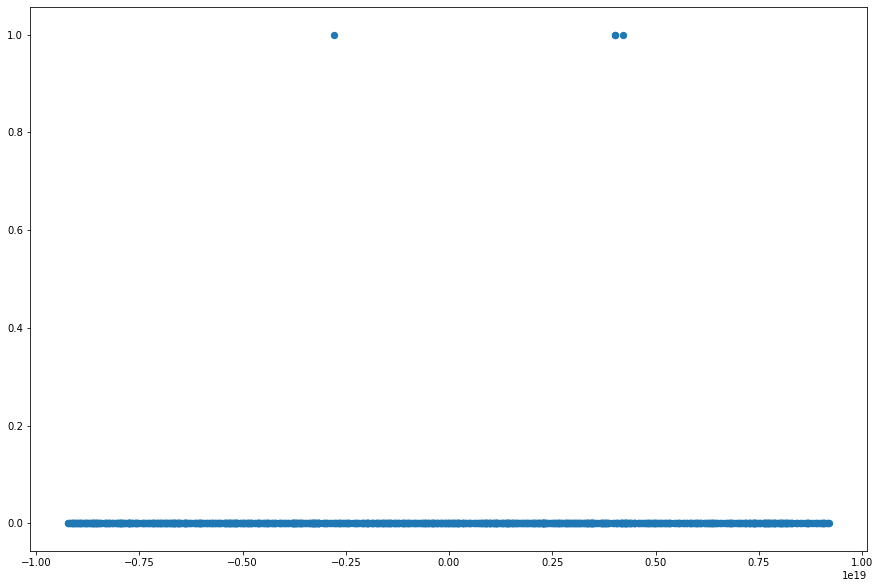

In [28]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

## 帧同步

### 构造建立模型

In [157]:
# 25参数
class GANframe(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(28,)))
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(14,)))
        self.oSeqGd.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(28, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(28,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(28,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(14, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [198]:
# 新建模型
tf.keras.backend.clear_session()
oGANframe = GANframe()

### 构造数据集

In [199]:
g_nFeatures = 28
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

# 为了把不做帧同步的部分也作为训练集
oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/sync/frame/samples/normal/train/preprocessed/samples*.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [200]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/sync/frame/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
        
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                           "parts/sync/frame/samples/normal/train/preprocessed/samples_noframe.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [201]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [202]:
strD = "(28,14)_D"
strA = "(28,14)_A"
strRootDir = "logs/nobranch/sync/frame"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)

In [203]:
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [204]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [205]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANframe)

727/10000

KeyboardInterrupt: 

In [206]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/sync/frame"
strModelsDir = os.path.join(strRootDir, "(28,14)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [207]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [208]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [209]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [210]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/frame/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/sync/frame/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [29]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/frame/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [30]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/sync/frame/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [31]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeanframe = np.mean(npNormalScores)
fSigmaframe = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanframe else ss.norm.sf(x, fMeanframe, fSigmaframe), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

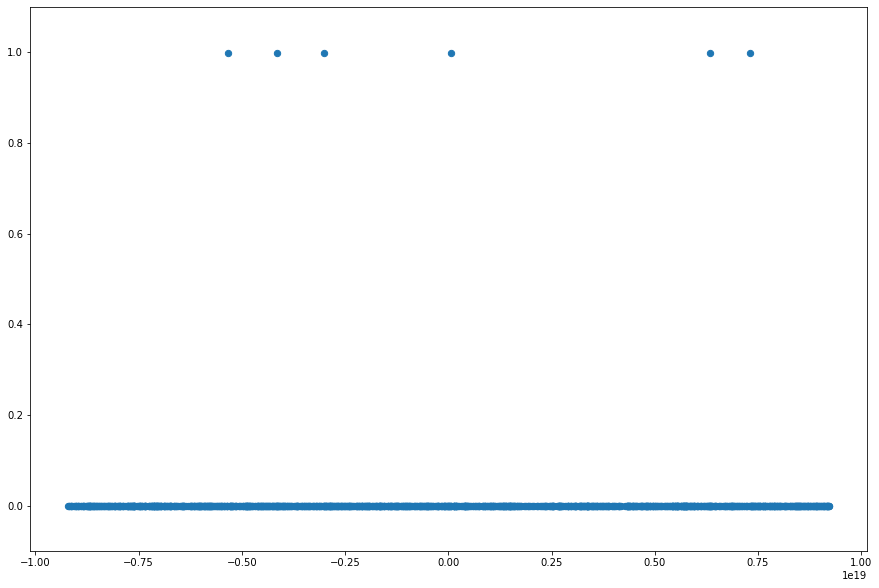

In [214]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.ylim([-0.1, 1.1])
plt.show()

## 计算正确率并存入json
将每一个异常样本存入一个json文件中，文件名为“任务名&解调器名&时间点.json”。

json结构如下：
* “中频输入”元组
    * 各个参数名及对应的参数值
    * 正确率
* “载波同步”元组
* “比特同步”元组
* “维特比译码”元组
* “帧同步”元组

In [666]:
"""
各个部分的异常样本index为准，寻找其对应的记录在分路之后各个部分的原始参数值
将每个记录各个阶段的参数键值对存入以该部分的名称为名的字典中，并在最后附加上该部分的正确率
最终
"""
sampleprobs = {"中频输入": [], "载波同步": []}#, "比特同步": [], "维特比译码": [], "帧同步": []}
ids = []
para_values = {"中频输入": [], "载波同步": []}#, "比特同步": [], "维特比译码": [], "帧同步": []}

def combine(section):
    sampleprobs[section].extend(probs.values[:, 0])
    para_values[section].extend([dict(zip(samples.columns, samples.loc[ind, :])) 
         for ind in samples.index])

for job in os.listdir(jobsdir):
    for demodir in getdirs(jobdir=os.path.join(jobsdir, job)):
        demod = os.path.split(demodir)[1]
        partdir = os.path.join(demodir, "parts/sync")
        
        """中频输入"""
        probs = pd.read_csv(os.path.join(partdir, "input/samples/abnormal/probs.csv"), \
            index_col="RECTIME")
        samples = pd.read_csv(os.path.join(partdir, "input/samples/abnormal/samples.csv"), index_col="RECTIME")
        combine("中频输入")
        ids.extend([job + "&" + demod + "&" + ind[-8:].replace(":", "_") for ind in probs.index])

        """载波同步"""
        probs = pd.read_csv(os.path.join(partdir, "carrier/samples/abnormal/probs.csv"), \
            index_col="RECTIME")
        samples = pd.read_csv(os.path.join(partdir, "carrier/samples/abnormal/samples.csv"), index_col="RECTIME")
        combine("载波同步")
        

        """
        #比特同步
        probs = pd.read_csv(os.path.join(partdir, "bit/samples/abnormal/preprocessed/probs.csv"), \
             index_col="RECTIME")
        samples = pd.read_csv(os.path.join(partdir, "bit/samples.csv"), index_col="RECTIME")
        combine("比特同步")

        #维特比译码
        probs = pd.read_csv(os.path.join(partdir, "vi/samples/abnormal/preprocessed/probs.csv"), \
             index_col="RECTIME")
        samples = pd.read_csv(os.path.join(partdir, "vi/samples.csv"), \
              index_col="RECTIME")
        combine("维特比译码")

        #帧同步
        probs = pd.read_csv(os.path.join(partdir, "frame/samples/abnormal/preprocessed/probs.csv"), \
             index_col="RECTIME")
        pdDfSamples = pd.read_csv(os.path.join(partdir, "frame/samples.csv"), \
              index_col="RECTIME")
        combine("帧同步")
        """

In [667]:
"""将每个异常样本的各个部分参数的原始值存入一个json文件
对于一条记录的相邻两个部分A、B而言，如果B对应的正确率小于A的正确率将近50%，那么判定部分B相对于部分A增加的
阶段发生故障，并在该部分对应的字典添上“故障”：Yes键值对，部分B后面的各个阶段的故障与否忽略不计
"""
jsondir = "../probs"
if os.path.exists(jsondir):
    shutil.rmtree(jsondir)
os.mkdir(jsondir)

for i in range(len(ids)):
    jsonobj = {}
    lastprob = 100.0
    for para in ["中频输入", "载波同步"]:#, "比特同步", "维特比译码", "帧同步"]:
        jsonobj[para] = para_values[para][i].copy()
        # 如果已经检测出了故障阶段（lastprob==-1），跳过此步
        if not lastprob == -1 and lastprob - sampleprobs[para][i] >= 50.0:
            jsonobj[para]["故障"] = "Yes"
            lastprob = -1
        elif not lastprob == -1:
            # 如果没发现故障阶段，则更新正确概率
            lastprob = sampleprobs[para][i]
    jsonstr = json.dumps(jsonobj, ensure_ascii=False)
    with open(os.path.join(jsondir, ids[i] + ".json"), "wb") as f:
        f.write(str.encode(jsonstr))

## 译码

### 构造建立模型

In [21]:
# 32参数
class GANdecode(object):
    def __init__(self):
        self.fn_makeGenerator()
        self.fn_makeDiscriminator()
        
    def fn_makeGenerator(self):
        self.oSeqGe = tf.keras.Sequential(name="Ge")
        self.oSeqGe.add(tf.keras.Input(shape=(32,)))
        self.oSeqGe.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe.add(tf.keras.layers.LeakyReLU())

        self.oSeqGd = tf.keras.Sequential(name="Gd")
        self.oSeqGd.add(tf.keras.Input(shape=(16,)))
        self.oSeqGd.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGd.add(tf.keras.layers.LeakyReLU())
        self.oSeqGd.add(tf.keras.layers.BatchNormalization())
        self.oSeqGd.add(tf.keras.layers.Dense(32, activation = tf.keras.activations.tanh, kernel_initializer="he_normal"))
        
        self.oSeqGe1 = tf.keras.Sequential(name="Ge1")
        self.oSeqGe1.add(tf.keras.Input(shape=(32,)))
        self.oSeqGe1.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        self.oSeqGe1.add(tf.keras.layers.BatchNormalization())
        self.oSeqGe1.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqGe1.add(tf.keras.layers.LeakyReLU())
        
    def fn_makeDiscriminator(self):
        self.oSeqDInner = tf.keras.Sequential(name="DInner")
        self.oSeqDInner.add(tf.keras.Input(shape=(32,)))
        self.oSeqDInner.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())
        self.oSeqDInner.add(tf.keras.layers.Dense(16, kernel_initializer="he_normal"))
        self.oSeqDInner.add(tf.keras.layers.LeakyReLU())
        self.oSeqDInner.add(tf.keras.layers.BatchNormalization())

        self.oSeqD = tf.keras.Sequential([
            self.oSeqDInner,
            tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
        ], name="D")

In [30]:
# 新建模型
oGANdecode = GANdecode()

### 构造数据集

In [31]:
g_nFeatures = 32
g_nBatchSize = 256

def fn_splitCsvLine(strLine):
    tensorDefs = [0.] * g_nFeatures
    tensorRecord = tf.io.decode_csv(strLine, record_defaults=tensorDefs)
    tensorX = tf.stack(tensorRecord)
    return tensorX

oDataset = tf.data.Dataset.list_files(strJobsDir + "/*/*/parts/decode/samples/normal/train/preprocessed/samples.csv")
oDataset = oDataset.interleave(lambda strSamplesFile: tf.data.TextLineDataset(strSamplesFile).skip(1), \
                              cycle_length=5, num_parallel_calls=5)
oDataset = oDataset.map(fn_splitCsvLine, g_nFeatures)
oDataset = oDataset.shuffle(1000)
oDataset = oDataset.batch(g_nBatchSize)

In [32]:
# 读入所有的训练样本，从而通过shape属性得到训练集大小，存入全局变量中
listPreprocessedNormalTrainingSamples = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strPreprocessedNormalTrainingSamplesFile = os.path.join(strDemodDir, \
                                                   "parts/decode/samples/normal/train/preprocessed/samples.csv")
        pdDfPreprocessedNormalTrainingSamples = pd.read_csv(strPreprocessedNormalTrainingSamplesFile)
        listPreprocessedNormalTrainingSamples.append(pdDfPreprocessedNormalTrainingSamples)
pdDfPreprocessedNormalTrainingSamples = pd.concat(listPreprocessedNormalTrainingSamples)
g_tensorNormalTrainingSamples = tf.constant(pdDfPreprocessedNormalTrainingSamples.values, dtype=tf.float32)
g_nTrainingSize = len(g_tensorNormalTrainingSamples)

### 训练

In [33]:
# g_nTrainingSize在中频控制已经设置好了
g_nEpochs = 10000
nSteps = g_nEpochs * g_nTrainingSize // g_nBatchSize
oExponentialDecay = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, nSteps, 1e-1)
oOptimizerG = tf.keras.optimizers.Adam(learning_rate=oExponentialDecay)
oOptimizerD = tf.keras.optimizers.SGD(learning_rate=oExponentialDecay)

In [34]:
strD = "(32,16)_D"
strA = "(32,16)_A"
strRootDir = "logs/nobranch/decode"
strDDir = os.path.join(strRootDir, strD)
strADir = os.path.join(strRootDir, strA)

In [35]:
if os.path.exists(strDDir):
    shutil.rmtree(strDDir)
if os.path.exists(strADir):
    shutil.rmtree(strADir)

In [36]:
oSummaryWriterDLoss = tf.summary.create_file_writer(strDDir)
oSummaryWriterALoss = tf.summary.create_file_writer(strADir)

In [37]:
oSeqGe = None
oSeqGd = None
oSeqGe1 = None
fn_train(oGANdecode)

2022/10000

KeyboardInterrupt: 

In [130]:
strGe = "Ge.h5"
strGd = "Gd.h5"
strGe1 = "Ge1.h5"
strRootDir = "models/nobranch/decode"
strModelsDir = os.path.join(strRootDir, "(32,16)")
strGeFile = os.path.join(strModelsDir, strGe)
strGdFile = os.path.join(strModelsDir, strGd)
strGe1File = os.path.join(strModelsDir, strGe1)

In [40]:
if os.path.exists(strModelsDir):
    shutil.rmtree(strModelsDir)
os.mkdir(strModelsDir)

In [41]:
oSeqGe.save(strGeFile)
oSeqGd.save(strGdFile)
oSeqGe1.save(strGe1File)

### 评估

In [131]:
oSeqGe = tf.keras.models.load_model(strGeFile)
oSeqGd = tf.keras.models.load_model(strGdFile)
oSeqGe1 = tf.keras.models.load_model(strGe1File)

In [43]:
# 算出正常训练集和异常测试集的分数
# train samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/decode/samples/normal/train")
        pdDfPreprocessedSamples = pd.read_csv(\
              os.path.join(strSamplesDir, "preprocessed/samples.csv"))
        pdDfSamples = pd.read_csv(os.path.join(strSamplesDir, "samples.csv"), index_col="RECTIME")
        # 分数csv包含scores列
        pdDfScores = fn_score(pdDfPreprocessedSamples)
        pdDfScores.index = pdDfSamples.index

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")
        
# Abnormal samples
for strJob in os.listdir(strJobsDir):
    listDemodDirs = fn_getDemodDirsOfAJob(os.path.join(strJobsDir, strJob))
    for strDemodDir in listDemodDirs:
        strSamplesDir = os.path.join(strDemodDir, "parts/decode/samples/abnormal")
        pdDfPreprocessedSamples = pd.read_csv(os.path.join(strSamplesDir, "preprocessed/samples.csv"), index_col="RECTIME")
        pdDfScores = fn_score(pdDfPreprocessedSamples)

        pdDfScores.to_csv(os.path.join(strSamplesDir, "preprocessed/scores.csv"), index_label="RECTIME")

In [134]:
# 读入正常测试样本和异常测试样本的分数，分别存入numpy数组
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strNormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/decode/samples/normal/train/preprocessed/scores.csv")
        pdDfNormalTestingScores = pd.read_csv(strNormalTestingScoresFile, index_col="RECTIME")
        
        if not pdDfNormalTestingScores.empty:
            listScores.append(pdDfNormalTestingScores["score"].values)
            
            # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfNormalTestingScores.index])
            
npNormalScores = np.concatenate(listScores)
npNormalX = np.concatenate(listX)

In [135]:
listScores = []
listX = []
for strJob in os.listdir(strJobsDir):
    strJobDir = os.path.join(strJobsDir, strJob)
    listDemodDirs = fn_getDemodDirsOfAJob(strJobDir)
    for strDemodDir in listDemodDirs:
        strAbnormalTestingScoresFile = os.path.join(strDemodDir, \
                                                  "parts/decode/samples/abnormal/preprocessed/scores.csv")
        pdDfAbnormalTestingScores = pd.read_csv(strAbnormalTestingScoresFile, index_col="RECTIME")
        if not pdDfAbnormalTestingScores.empty:
            listScores.append(pdDfAbnormalTestingScores["score"].values)
            
             # 分数的横坐标——用crc编码“解调器名+上报时间”
            strDemod = os.path.split(strDemodDir)[1]
            listX.append([hash(strDemod + strIndex) for strIndex in pdDfAbnormalTestingScores.index])
            
npAbnormalScores = np.concatenate(listScores)
npAbnormalX = np.concatenate(listX)

In [136]:
"""
通过正常训练样本的分数计算相应的正太分布，利用正态分布计算异常样本该部分正确的概率
"""
fMeandecode = np.mean(npNormalScores)
fSigmadecode = np.var(npNormalScores)
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanframe else ss.norm.sf(x, fMeandecode, fSigmadecode), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))

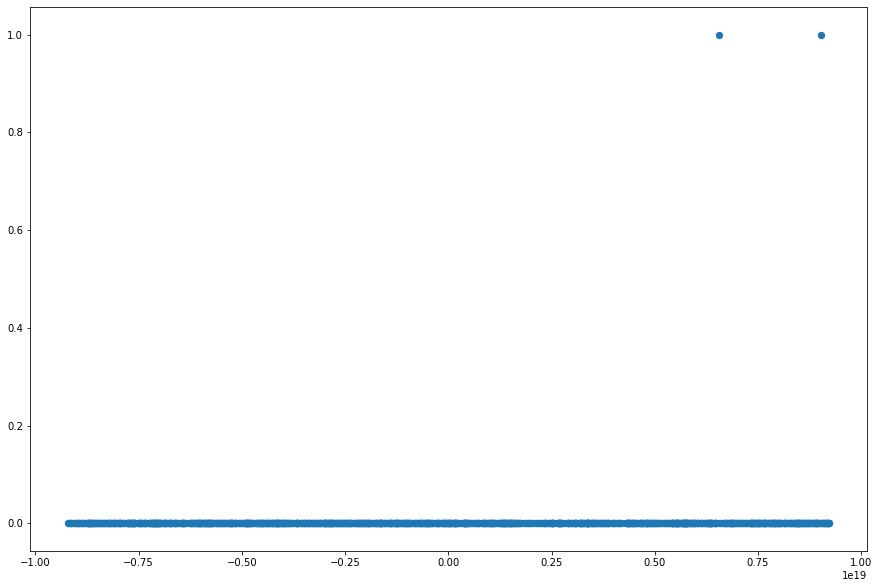

In [137]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.show()

### 用随机产生的伪样本测试模型的有效性

In [153]:
pdDfFakeSamples = pd.DataFrame(data=np.random.randn(100, 32), index=["Fake"] * 100)

In [154]:
npAbnormalScores = fn_score(pdDfFakeSamples).values

In [155]:
npAbnormalprob = np.apply_along_axis(lambda x: 1 if x <= fMeanframe else ss.norm.sf(x, fMeandecode, fSigmadecode), 1, \
     npAbnormalScores[:, np.newaxis].astype(np.float64))
npAbnormalX = range(len(npAbnormalprob))

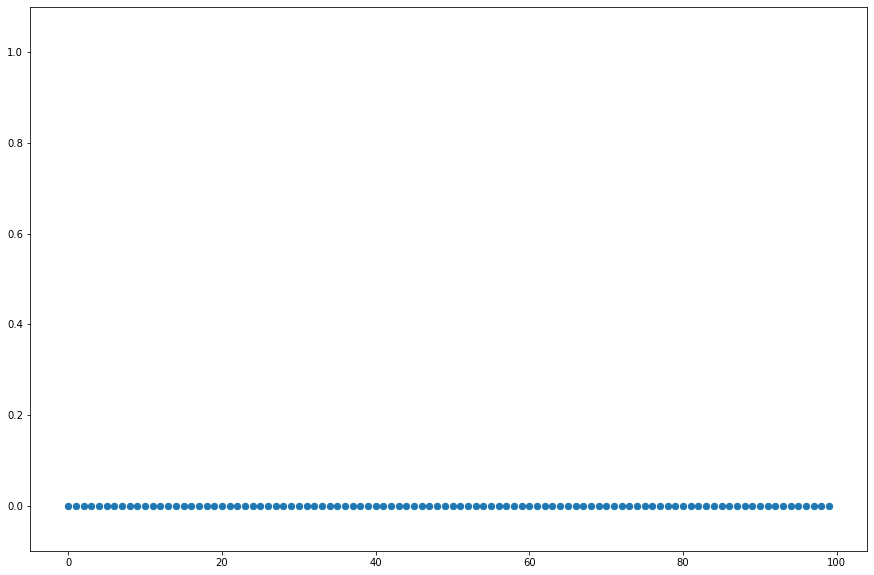

In [156]:
plt.figure(figsize=(15, 10))
plt.scatter(npAbnormalX, npAbnormalprob, s=40)
plt.ylim([-0.1, 1.1])
plt.show()